In [1]:
#combine files 
import glob 
import os
#clean 
import string
import pandas as pd
import numpy as np
import emoji
import nltk
import re 
from cleantext import clean
#sleep timer 
import time 
import logging
import threading
#show most common words
from collections import Counter
#word cloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('JNE_batam.csv')
column_titles = ['rating','caption']
df1 = df.reindex(columns=column_titles)
df1 = df1.dropna()

In [3]:
df1['middle'] = df1['caption'].str.split(")").str[1] 
df1['reviews'] = df1['middle'].str.split("(").str[0]

df1 = df1.reset_index()

In [4]:
df1['reviews'].fillna('0', inplace = True)
for i, row in df1.iterrows(): 
    review = row['reviews']
    if review == '0':
        df1['reviews'][i] = review.replace('0', row['caption'])

/var/folders/5w/0kxl7gbj5vqb93sccvkxwrzc0000gn/T/ipykernel_53706/1854476216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['reviews'][i] = review.replace('0', row['caption'])


### Clean the data

In [6]:

from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers and lemmatize/stem.'''
    text = str(text).lower()
    text = re.sub('#\w*', '', text)
    text = re.sub('@\w*', '', text)    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = clean(text, no_emoji=True)
    text = emoji.demojize(text, delimiters=("", "")) #change emoji into text 
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

# Let's take a look at the updated text
df1['reviews'] = pd.DataFrame(df1['reviews'].apply(clean_text_round1))

### Sentiment analysis 


In [7]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
def clean_text_round2(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output
df1['reviews'] = pd.DataFrame(df1['reviews'].apply(clean_text_round2))


In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    if sentiment_dict['compound'] >= 0.05 : 
       return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 : 
        return "Negative"
    else : 
       return "Neutral"
        
df1['sentiment'] = pd.DataFrame(df1['reviews'].apply(sentiment_scores))

In [10]:
column_titles = ['rating','reviews','sentiment']
df1 = df1.reindex(columns=column_titles)
df1.to_csv('jne_Greviews.csv')

In [13]:
df_neg = df1.drop(df1[df1['sentiment'] != 'Negative'].index)
df_neg

,rating,reviews,sentiment
6,1.0,njir bad really slow point use jne ...,Negative
7,3.0,bit surprised little disappointed shipping bat...,Negative
8,1.0,worst jne bad service handle product bad good ...,Negative
12,1.0,better use jne useless slow work contact picke...,Negative
13,1.0,day still stuck batam there update anyway im t...,Negative
...,...,...,...
556,1.0,bad disappointing solution reason shortage air...,Negative
558,1.0,please package sy dr customer ga still batam w...,Negative
559,1.0,advice provide service cant serve well ...,Negative
560,1.0,say overload piled warehouse airport come fell...,Negative


In [14]:
#combining the text into one long string for word cloud 
cloud_string = df_neg['reviews'].str.cat(sep=' ')

In [15]:
# Let's first pull out the top 30 words for each category
words = []
for word in cloud_string.split():
        words.append(word)
Counter(words).most_common()

[('...', 135),
 ('bad', 84),
 ('batam', 80),
 ('jne', 77),
 ('service', 76),
 ('package', 53),
 ('day', 38),
 ('still', 36),
 ('week', 31),
 ('really', 29),
 ('item', 29),
 ('delivery', 27),
 ('good', 25),
 ('sent', 24),
 ('disappointed', 20),
 ('even', 19),
 ('time', 18),
 ('dont', 17),
 ('use', 16),
 ('please', 16),
 ('customer', 16),
 ('slow', 15),
 ('already', 15),
 ('using', 14),
 ('arrived', 14),
 ('though', 13),
 ('want', 13),
 ('phone', 13),
 ('stuck', 12),
 ('long', 12),
 ('process', 12),
 ('worst', 11),
 ('send', 11),
 ('shipment', 11),
 ('doesnt', 11),
 ('center', 10),
 ('yet', 10),
 ('one', 10),
 ('also', 10),
 ('overload', 10),
 ('work', 9),
 ('sorting', 9),
 ('courier', 9),
 ('reason', 9),
 ('disappointing', 9),
 ('online', 9),
 ('said', 9),
 ('delivered', 8),
 ('always', 8),
 ('severe', 8),
 ('hasnt', 8),
 ('better', 7),
 ('contact', 7),
 ('address', 7),
 ('month', 7),
 ('call', 7),
 ('didnt', 7),
 ('status', 7),
 ('expedition', 7),
 ('star', 7),
 ('number', 7),
 ('shop'

In [16]:
#add meaningless words to stopwords
add_stop_words = ['...' , 'call', 'dont', 'cant']
stop_words = add_stop_words + stop 

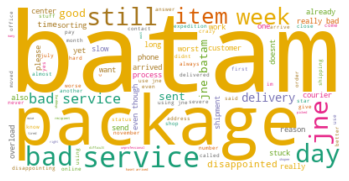

In [17]:
#wordcloud for top 100 words 
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, max_words = 100)

wordcloud = wc.generate(cloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

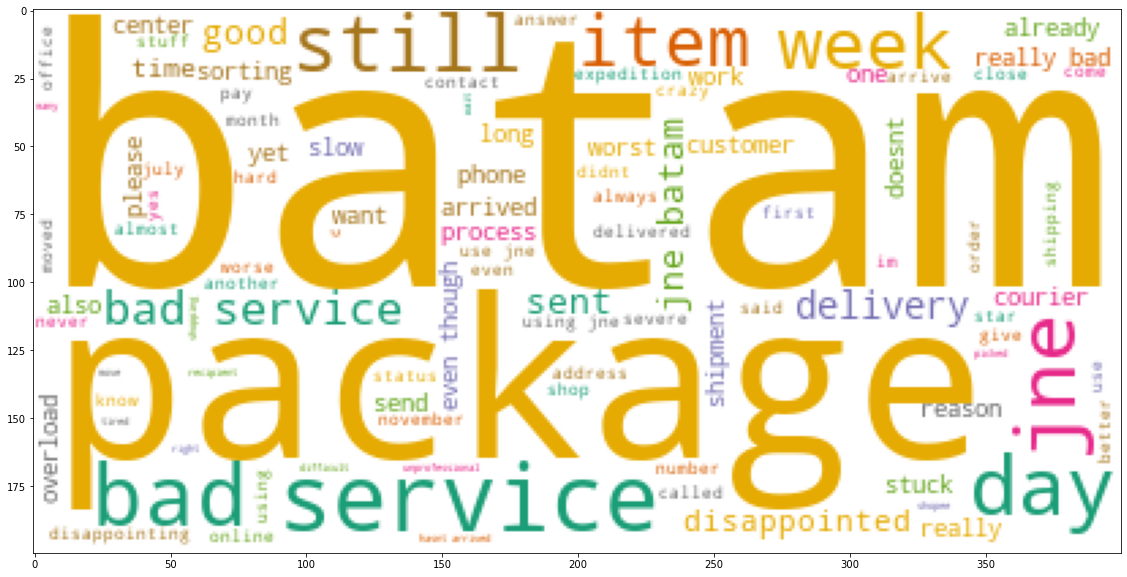

In [18]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)

In [22]:
late_words = ['slow', 'late', 'long']
df_late = df_neg[df_neg['reviews'].str.contains('|'.join(late_words))]
df_late = df_late.rename(columns ={'reviews':'Late reviews'})

In [23]:
df_late

,rating,Late reviews,sentiment
6,1.0,njir bad really slow point use jne ...,Negative
12,1.0,better use jne useless slow work contact picke...,Negative
15,1.0,send document incidentally include taxable goo...,Negative
33,1.0,bad long day since package moving ...,Negative
53,1.0,jne never worked slowly good period jakarta de...,Negative
116,1.0,bad service slow delivery,Negative
131,1.0,took long get loss customer took long customer...,Negative
148,1.0,delivery slow use regular jne batam pekanbaru ...,Negative
157,1.0,service bad slow delivery huh,Negative
164,1.0,jne really bad stuff already day still sorted ...,Negative


In [24]:
df_late.to_csv('Late_reviews_jne.csv')